<a href="https://colab.research.google.com/github/Mithunjha/PDAC_Prediction/blob/main/Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminaries

Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
from glob import glob
import scipy 
import scipy.io
import pywt
import pywt.data
!pip install pyfeats
import pyfeats as pf
import h5py
import pandas as pd
from skimage.feature import greycomatrix, greycoprops
from google.colab import drive
import warnings

Connecting to Google drive

In [ ]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/Medical Imaging/'

/content/drive/MyDrive/Medical Imaging


In [ ]:
!ls '/content/drive/MyDrive/Medical Imaging/'

base.mat	       __pycache__     testlabel.h5	WEIGHT.h5
extracted_features.h5  RANKED.h5       traindata_fs.h5
IFLS.py		       testdata_fs.h5  trainlabel.h5


In [ ]:
# Load the data
Data = scipy.io.loadmat("base.mat")

In [ ]:
# Get the field names
for fn in Data.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(Data[fn])))

User uploaded file "__header__" with length 76 bytes
User uploaded file "__version__" with length 3 bytes
User uploaded file "__globals__" with length 0 bytes
User uploaded file "ROIs" with length 312 bytes
User uploaded file "li" with length 1 bytes


In [ ]:
# RoIs 
data = Data["ROIs"]

In [ ]:
labels = Data["li"][0][0][0] # Labels of whole dataset
split_ratio = Data["li"][0][0][1] # Split ration
traindata_indices = Data["li"][0][0][2] # Traindata indices given
testdata_indices = Data["li"][0][0][3] # Testdata indices given
traindata_labels = Data["li"][0][0][4] # Labels of given traindata
testdata_labels = Data["li"][0][0][5] # Labels of given testdata

In [ ]:
print(f"length of labels : {len(labels)}")
print(f"Split ratio : {split_ratio}")
print(f"length of train indices : {len(traindata_indices)}")
print(f"length of test indices : {len(testdata_indices)}")
print(f"length of train data labels : {len(traindata_labels)}")
print(f"length of test data labels : {len(testdata_labels)}")

length of labels : 312
Split ratio : [[0.7]]
length of train indices : 218
length of test indices : 94
length of train data labels : 218
length of test data labels : 94


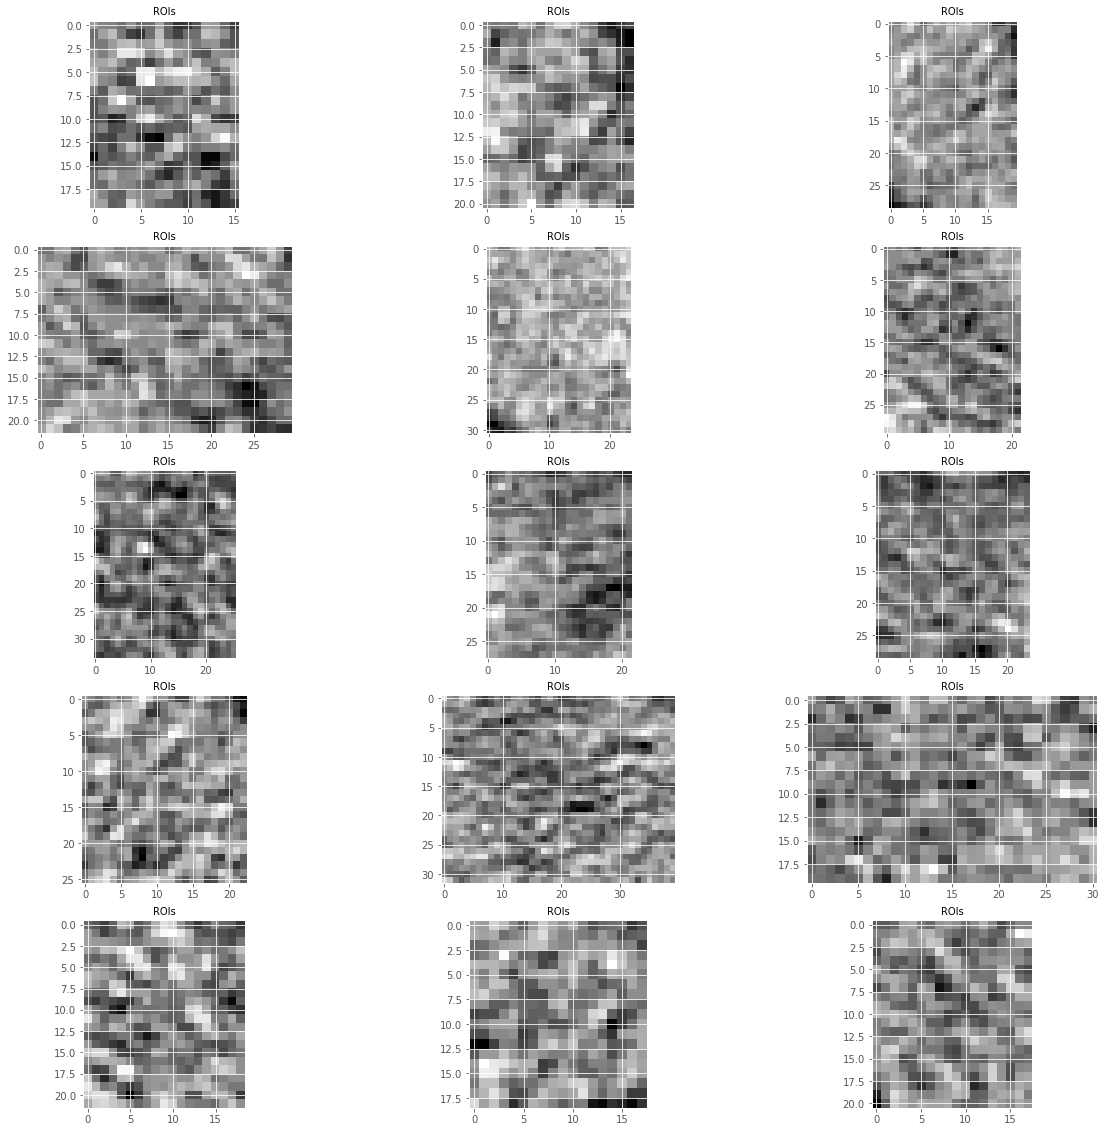

In [ ]:
# print ROIs (first 15)
rows,cols=5,3
fig=plt.figure(figsize=(20,20))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img=data[i-1][0]
    plt.imshow(img,cmap='gray')
    plt.title("ROIs",fontsize = 10)
plt.show()

Index : 283
label of the image 2


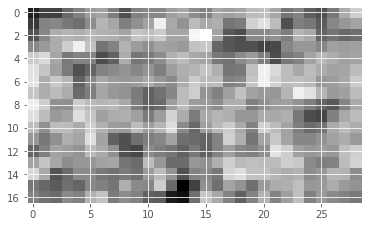

In [ ]:
index = 109
img = data[traindata_indices[index][0]][0]
print(f'Index : {traindata_indices[index][0]}')
label = traindata_labels[index][0]
plt.imshow(img, cmap = 'gray')
print(f"label of the image {label}")

# Wavelet Decomposition

Discrete 2D wavelet decomposition

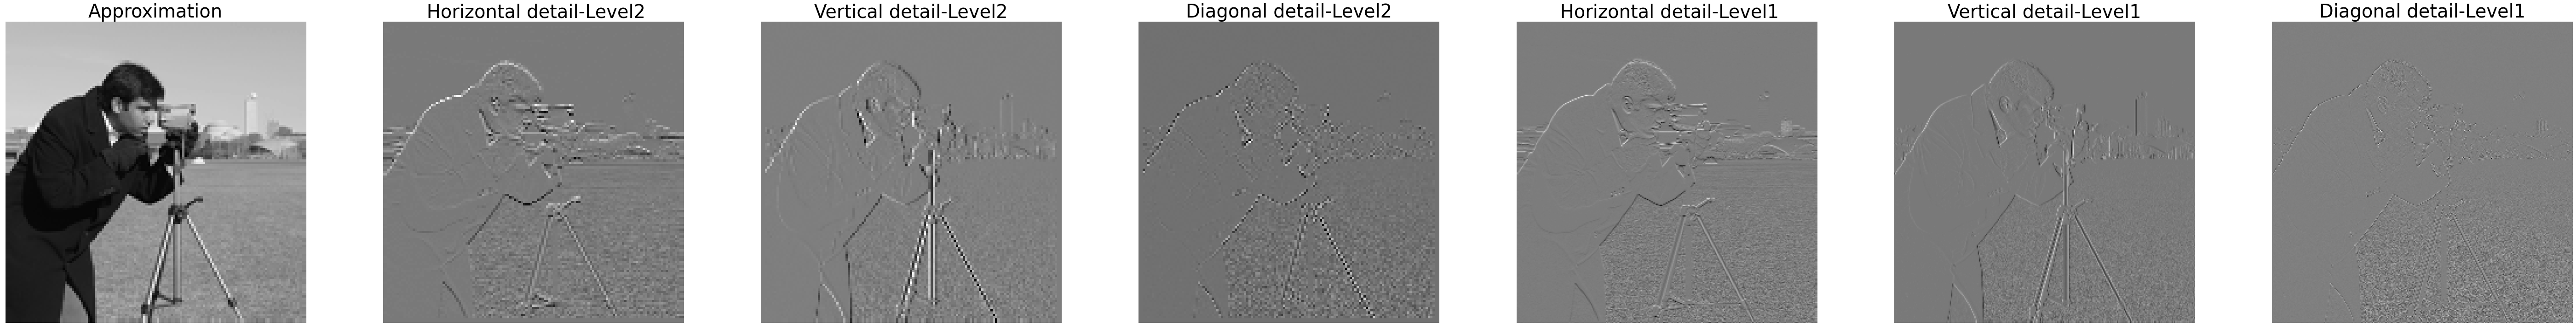

In [ ]:
# Sample code to see effect of wavelet decomposition

# Load image
original = pywt.data.camera()

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail-Level2','Vertical detail-Level2', 'Diagonal detail-Level2', ' Horizontal detail-Level1','Vertical detail-Level1', 'Diagonal detail-Level1']

coeffs2 = pywt.wavedec2(original, 'bior1.3', level=2)
LL, (LH2, HL2, HH2), (LH, HL, HH)= coeffs2
fig = plt.figure(figsize=(80, 10))
for i, a in enumerate([LL, LH2, HL2, HH2, LH, HL, HH]):
    ax = fig.add_subplot(1, 7, i + 1)
    ax.imshow(a, cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=40)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [ ]:
# wavelet 2d decomposition
def wavelet_components(input_image, wavelet_name = 'db3', is_plot = False ):
  coeffs1 = pywt.wavedec2(input_image, wavelet_name, level=1)
  A1, _ = coeffs1
  coeffs2 = pywt.wavedec2(input_image, wavelet_name, level=2)
  A2, (H2, V2, D2), (H1, V1, D1)= coeffs2
  if is_plot == True:
    titles = ['Approximation-Level2', ' Horizontal detail-Level2',
              'Vertical detail-Level2', 'Diagonal detail-Level2', 'Approximation-Level1', ' Horizontal detail-Level1',
              'Vertical detail-Level1', 'Diagonal detail-Level1']

    fig = plt.figure(figsize=(80, 10))
    for i, a in enumerate([A2, H2, V2, D2, A1, H1, V1, D1]):
        ax = fig.add_subplot(1, 8, i + 1)
        #print(a.shape)
        ax.imshow(a, cmap=plt.cm.gray)
        ax.set_title(titles[i], fontsize=30)
        ax.set_xticks([])
        ax.set_yticks([])

    fig.tight_layout()
    plt.show()
  return A2, H2, V2, D2, A1, H1, V1, D1

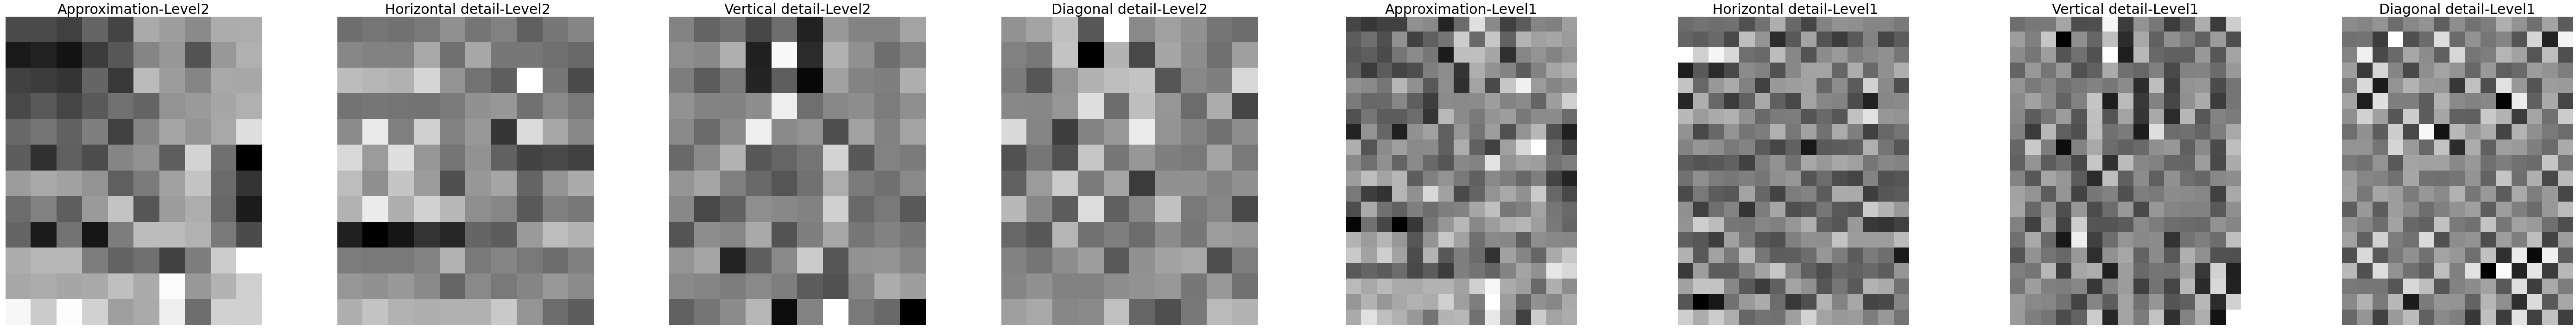

Text(0.5, 1.0, 'Input Image')

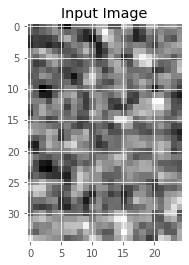

In [ ]:
# plot wavelet decomosition of a random ROI
original = data[15][0]
A2, H2, V2, D2, A1, H1, V1, D1 = wavelet_components(original,is_plot=True)
plt.imshow(original,cmap = 'gray')
plt.title('Input Image')

Find the AVMs - Average of minimums and maximums

In [ ]:
warnings.filterwarnings("ignore")

def find_AVM(traindata_indices,traindata_labels):

  A2_1_min = []; H2_1_min = []; V2_1_min = []; D2_1_min = []; A1_1_min = []; H1_1_min = [];  V1_1_min = []; D1_1_min = [];
  A2_2_min = []; H2_2_min = []; V2_2_min = []; D2_2_min = []; A1_2_min = []; H1_2_min = [];  V1_2_min = []; D1_2_min = [];

  A2_1_max = []; H2_1_max = []; V2_1_max = []; D2_1_max = []; A1_1_max = []; H1_1_max = [];  V1_1_max = []; D1_1_max = [];
  A2_2_max = []; H2_2_max = []; V2_2_max = []; D2_2_max = []; A1_2_max = []; H1_2_max = [];  V1_2_max = []; D1_2_max = [];

  nA = 0;
  nB = 0;
  for i in range(0,len(traindata_labels)):
    label = traindata_labels[i][0]
    if label == 1:
      image = data[traindata_indices[i][0]][0] #data[i][0]
      A2, H2, V2, D2, A1, H1, V1, D1 = wavelet_components(image)
      nA+=1
      A2_1_min.append(np.min(A2));H2_1_min.append(np.min(H2));V2_1_min.append(np.min(V2));D2_1_min.append(np.min(D2));
      A1_1_min.append(np.min(A1));H1_1_min.append(np.min(H1));V1_1_min.append(np.min(V1));D1_1_min.append(np.min(D1));

      A2_1_max.append(np.max(A2));H2_1_max.append(np.max(H2));V2_1_max.append(np.max(V2));D2_1_max.append(np.max(D2));
      A1_1_max.append(np.max(A1));H1_1_max.append(np.max(H1));V1_1_max.append(np.max(V1));D1_1_max.append(np.max(D1));

    elif label == 2:
      image = data[traindata_indices[i][0]][0]
      A2, H2, V2, D2, A1, H1, V1, D1 = wavelet_components(image)
      nB+=1
      A2_2_min.append(np.min(A2));H2_2_min.append(np.min(H2));V2_2_min.append(np.min(V2));D2_2_min.append(np.min(D2));
      A1_2_min.append(np.min(A1));H1_2_min.append(np.min(H1));V1_2_min.append(np.min(V1));D1_2_min.append(np.min(D1));

      A2_2_max.append(np.max(A2));H2_2_max.append(np.max(H2));V2_2_max.append(np.max(V2));D2_2_max.append(np.max(D2));
      A1_2_max.append(np.max(A1));H1_2_max.append(np.max(H1));V1_2_max.append(np.max(V1));D1_2_max.append(np.max(D1));

  s_A2_1 = np.mean(A2_1_min); s_H2_1 = np.mean(H2_1_min); s_V2_1 = np.mean(V2_1_min); s_D2_1 = np.mean(D2_1_min);
  s_A1_1 = np.mean(A1_1_min); s_H1_1 = np.mean(H1_1_min); s_V1_1 = np.mean(V1_1_min); s_D1_1 = np.mean(D1_1_min);

  t_A2_1 = np.mean(A2_1_max); t_H2_1 = np.mean(H2_1_max); t_V2_1 = np.mean(V2_1_max); t_D2_1 = np.mean(D2_1_max);
  t_A1_1 = np.mean(A1_1_max); t_H1_1 = np.mean(H1_1_max); t_V1_1 = np.mean(V1_1_max); t_D1_1 = np.mean(D1_1_max);

  s_A2_2 = np.mean(A2_2_min); s_H2_2 = np.mean(H2_2_min); s_V2_2 = np.mean(V2_2_min); s_D2_2 = np.mean(D2_2_min);
  s_A1_2 = np.mean(A1_2_min); s_H1_2 = np.mean(H1_2_min); s_V1_2 = np.mean(V1_2_min); s_D1_2 = np.mean(D1_2_min);

  t_A2_2 = np.mean(A2_2_max); t_H2_2 = np.mean(H2_2_max); t_V2_2 = np.mean(V2_2_max); t_D2_2 = np.mean(D2_2_max);
  t_A1_2 = np.mean(A1_2_max); t_H1_2 = np.mean(H1_2_max); t_V1_2 = np.mean(V1_2_max); t_D1_2 = np.mean(D1_2_max);


  s_A2 = min(s_A2_1,s_A2_2); s_H2 = min(s_H2_1,s_H2_2); s_V2 = min(s_V2_1,s_V2_2); s_D2 = min(s_D2_1,s_D2_2); 
  s_A1 = min(s_A1_1,s_A1_2); s_H1 = min(s_H1_1,s_H1_2); s_V1 = min(s_V1_1,s_V1_2); s_D1 = min(s_D1_1,s_D1_2); 

  t_A2 = max(t_A2_1,t_A2_2); t_H2 = max(t_H2_1,t_H2_2); t_V2 = max(t_V2_1,t_V2_2); t_D2 = max(t_D2_1,t_D2_2); 
  t_A1 = max(t_A1_1,t_A1_2); t_H1 = max(t_H1_1,t_H1_2); t_V1 = max(t_V1_1,t_V1_2); t_D1 = max(t_D1_1,t_D1_2); 

  return s_A2,s_H2,s_V2,s_D2,s_A1,s_H1,s_V1,s_D1,t_A2,t_H2,t_V2,t_D2,t_A1,t_H1,t_V1,t_D1

Discretize the wavelet components

In [ ]:
# find the histogram bin intervals
def bins(minimum,maximum,no_of_bins=8):
  w = (maximum - minimum) / no_of_bins
  arr = []
  for i in range(0, no_of_bins+1):
    arr = arr + [minimum + w * i]
  return arr

In [ ]:
#discretize each component based on the intervals and AVMs
def discretize(data,j,is_plot = False):
  image = data[j][0]
  A2, H2, V2, D2, A1, H1, V1, D1 = wavelet_components(image)
  s_A2,s_H2,s_V2,s_D2,s_A1,s_H1,s_V1,s_D1,t_A2,t_H2,t_V2,t_D2,t_A1,t_H1,t_V1,t_D1 = find_AVM(traindata_indices,traindata_labels)
  interval_A2 = bins(s_A2, t_A2)
  interval_H2 = bins(s_H2, t_H2)
  interval_V2 = bins(s_V2, t_V2)
  interval_D2 = bins(s_D2, t_D2)
  interval_A1 = bins(s_A1, t_A1)
  interval_H1 = bins(s_H1, t_H1)
  interval_V1 = bins(s_V1, t_V1)
  interval_D1 = bins(s_D1, t_D1)
  A2_new = np.digitize(A2,interval_A2[1:-1])
  H2_new = np.digitize(H2,interval_H2[1:-1])
  V2_new = np.digitize(V2,interval_V2[1:-1])
  D2_new = np.digitize(D2,interval_D2[1:-1])
  A1_new = np.digitize(A1,interval_A1[1:-1])
  H1_new = np.digitize(H1,interval_H1[1:-1])
  V1_new = np.digitize(V1,interval_V1[1:-1])
  D1_new = np.digitize(D1,interval_D1[1:-1])

  if is_plot == True:
    fig, ax = plt.subplots(1,8, figsize=(50,10));
    ax[0].imshow(A2_new, cmap='gray'), ax[0].set_title(f'{j+1} Approximate - level 2');
    ax[1].imshow(H2_new, cmap='gray'), ax[1].set_title(f'{j+1} Horizontal - level 2');
    ax[2].imshow(V2_new, cmap='gray'), ax[2].set_title(f'{j+1} Vertical - level 2');
    ax[3].imshow(D2_new, cmap='gray'), ax[3].set_title(f'{j+1} Diagonal - level 2');
    ax[4].imshow(A1_new, cmap='gray'), ax[4].set_title(f'{j+1} Approximate - level 1');
    ax[5].imshow(H1_new, cmap='gray'), ax[5].set_title(f'{j+1} Horizontal - level 1');
    ax[6].imshow(V1_new, cmap='gray'), ax[6].set_title(f'{j+1} Vertical - level 1');
    ax[7].imshow(D1_new, cmap='gray'), ax[7].set_title(f'{j+1} Diagonal - level 1');


  return A2_new, H2_new, V2_new, D2_new, A1_new, H1_new, V1_new, D1_new



In [ ]:
# uncomment to plot discretized wavelet components
# for j in range(0,1):
#   A2_new, H2_new, V2_new, D2_new, A1_new, H1_new, V1_new, D1_new = discretize(data,j,is_plot=True)

Statistical feature extraction

In [ ]:

def features(component,CS =False, H =False, COM =False, RLM = False):
  feature_list = []
  title_base = []
  if CS == True:
    mean = np.mean(component); feature_list.append(mean); title_base.append('mean')
    std = np.std(component); feature_list.append(std); title_base.append('std')
    energy = np.mean(component**2); feature_list.append(energy); title_base.append('energy')

  if H == True:
    features_h, labels = pf.fos(component,mask=None)
    h_mean = features_h[0]; feature_list.append(h_mean); title_base.append('h_mean')
    h_variance = features_h[1]; feature_list.append(h_variance); title_base.append('h_variance')
    h_skewness = features_h[4]; feature_list.append(h_skewness); title_base.append('h_skewness')
    h_kurtosis = features_h[5]; feature_list.append(h_kurtosis); title_base.append('h_kurtosis')
    h_entropy = features_h[7]; feature_list.append(h_entropy); title_base.append('h_entropy')


  if COM == True:
    g = greycomatrix(component, [1, 2], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=no_of_bins,normed=True, symmetric=True)
    contrast_d1, contrast_d2 = np.mean(greycoprops(g, 'contrast'),axis=1)
    feature_list.append(contrast_d1); title_base.append('contrast_d1'); feature_list.append(contrast_d2); title_base.append('contrast_d2')

    g_energy_d1, g_energy_d2 = np.mean(greycoprops(g, 'energy'),axis=1)
    feature_list.append(g_energy_d1); title_base.append('g_energy_d1');feature_list.append(g_energy_d2); title_base.append('g_energy_d2')

    homogeneity_d1, homogeneity_d2 = np.mean(greycoprops(g, 'homogeneity'),axis=1)
    feature_list.append(homogeneity_d1); title_base.append('homogeneity_d1');feature_list.append(homogeneity_d2); title_base.append('homogeneity_d2')

    correlation_d1, correlation_d2 = np.mean(greycoprops(g, 'correlation'),axis=1)
    feature_list.append(correlation_d1); title_base.append('correlation_d1');feature_list.append(correlation_d2); title_base.append('correlation_d2');
  
  if RLM == True:
    features, labels = pf.glrlm_features(component, mask=None, Ng=no_of_bins)
    ShortRunEmphasis = features[0]; feature_list.append(ShortRunEmphasis); title_base.append('ShortRunEmphasis')
    LongRunEmphasis = features[1]; feature_list.append(LongRunEmphasis); title_base.append('LongRunEmphasis')
    GrayLevelNonUniformity = features[2]; feature_list.append(GrayLevelNonUniformity); title_base.append('GrayLevelNonUniformity')
    RunLengthNonUniformity = features[3]; feature_list.append(RunLengthNonUniformity); title_base.append('RunLengthNonUniformity')
    RunPercentage = features[4]; feature_list.append(RunPercentage); title_base.append('RunPercentage')
    LowGrayLevelRunEmphasis = features[5]; feature_list.append(LowGrayLevelRunEmphasis); title_base.append('LowGrayLevelRunEmphasis')
    HighGrayLevelRunEmphasis = features[6]; feature_list.append(HighGrayLevelRunEmphasis); title_base.append('HighGrayLevelRunEmphasis')
    ShortLowGrayLevelEmphasis = features[7]; feature_list.append(ShortLowGrayLevelEmphasis); title_base.append('ShortLowGrayLevelEmphasis')
    ShortRunHighGrayLevelEmphasis = features[8]; feature_list.append(ShortRunHighGrayLevelEmphasis); title_base.append('ShortRunHighGrayLevelEmphasis')
    # LongRunLowGrayLevelEmphasis = features[9]; feature_list.append(LongRunLowGrayLevelEmphasis); title_base.append('LongRunLowGrayLevelEmphasis')
    LongRunHighGrayLevelEmphasis = features[10]; feature_list.append(LongRunHighGrayLevelEmphasis); title_base.append('LongRunHighGrayLevelEmphasis')

 
  return feature_list, title_base

In [ ]:
extracted_features = []
no_of_bins=8
cs = True; h=True; com=True; rlm = True;
for j in range(0,len(labels)):
  A2_new, H2_new, V2_new, D2_new, A1_new, H1_new, V1_new, D1_new = discretize(data,j)
  title_base = features(A2_new, CS = cs, H=h, COM =com, RLM = rlm)[1]
  feature_list = (features(A2_new, CS = cs, H=h, COM =com, RLM = rlm)[0] + features(H2_new, CS = cs, H=h, COM =com, RLM = rlm)[0] + 
                  features(V2_new, CS = cs, H=h, COM =com, RLM = rlm)[0] + features(D2_new, CS = cs, H=h, COM =com, RLM = rlm)[0]+ 
                  features(A1_new, CS = cs, H=h, COM =com, RLM = rlm)[0] + features(H1_new, CS = cs, H=h, COM =com, RLM = rlm)[0] + 
                  features(V1_new, CS = cs, H=h, COM =com, RLM = rlm)[0] + features(D1_new, CS = cs, H=h, COM =com, RLM = rlm)[0])
  extracted_features.append(feature_list)
print(f"Length of the extracted fetures {len(extracted_features)}")


Length of the extracted fetures 312


In [ ]:
print(f"Length of the title base {len(title_base)}")
title_addon = ['A2', 'H2', 'V2', 'D2', 'A1', 'H1', 'V1', 'D1']
print(f"Length of the components {len(title_addon)}")

title = []
for l in title_addon:
  for k in title_base:
    title.append(k+"_"+str(l))

print(f"Length of the title base {len(title)}")

Length of the title base 26
Length of the components 8
Length of the title base 208


In [ ]:
extracted_features = np.array(extracted_features)
with h5py.File('/content/drive/MyDrive/Medical Imaging/extracted_features.h5', 'w') as f:
    dset = f.create_dataset("data", data = extracted_features)

In [ ]:
# with h5py.File('/content/drive/MyDrive/Medical Imaging/extracted_features.h5', 'r') as f:
#    a_group_key = list(f.keys())[0]
#    extracted_features = np.array((f[a_group_key]))

In [ ]:
extracted_features = pd.DataFrame(extracted_features)
extracted_features.columns = title
extracted_features

,mean_A2,std_A2,energy_A2,h_mean_A2,h_variance_A2,h_skewness_A2,h_kurtosis_A2,h_entropy_A2,contrast_d1_A2,contrast_d2_A2,g_energy_d1_A2,g_energy_d2_A2,homogeneity_d1_A2,homogeneity_d2_A2,correlation_d1_A2,correlation_d2_A2,ShortRunEmphasis_A2,LongRunEmphasis_A2,GrayLevelNonUniformity_A2,RunLengthNonUniformity_A2,RunPercentage_A2,LowGrayLevelRunEmphasis_A2,HighGrayLevelRunEmphasis_A2,ShortLowGrayLevelEmphasis_A2,ShortRunHighGrayLevelEmphasis_A2,LongRunHighGrayLevelEmphasis_A2,mean_H2,std_H2,energy_H2,h_mean_H2,h_variance_H2,h_skewness_H2,h_kurtosis_H2,h_entropy_H2,contrast_d1_H2,contrast_d2_H2,g_energy_d1_H2,g_energy_d2_H2,homogeneity_d1_H2,homogeneity_d2_H2,...,homogeneity_d1_V1,homogeneity_d2_V1,correlation_d1_V1,correlation_d2_V1,ShortRunEmphasis_V1,LongRunEmphasis_V1,GrayLevelNonUniformity_V1,RunLengthNonUniformity_V1,RunPercentage_V1,LowGrayLevelRunEmphasis_V1,HighGrayLevelRunEmphasis_V1,ShortLowGrayLevelEmphasis_V1,ShortRunHighGrayLevelEmphasis_V1,LongRunHighGrayLevelEmphasis_V1,mean_D1,std_D1,energy_D1,h_mean_D1,h_variance_D1,h_skewness_D1,h_kurtosis_D1,h_entropy_D1,contrast_d1_D1,contrast_d2_D1,g_energy_d1_D1,g_energy_d2_D1,homogeneity_d1_D1,homogeneity_d2_D1,correlation_d1_D1,correlation_d2_D1,ShortRunEmphasis_D1,LongRunEmphasis_D1,GrayLevelNonUniformity_D1,RunLengthNonUniformity_D1,RunPercentage_D1,LowGrayLevelRunEmphasis_D1,HighGrayLevelRunEmphasis_D1,ShortLowGrayLevelEmphasis_D1,ShortRunHighGrayLevelEmphasis_D1,LongRunHighGrayLevelEmphasis_D1
0,1.464286,0.822980,2.821429,1.470028,0.679985,-0.674185,2.356045,1.076812,0.862989,0.989286,0.438536,0.432693,0.715572,0.684286,0.346436,0.238952,0.637638,5.088935,11.550161,10.678583,0.450893,3.488613e+15,0.893340,3.488613e+15,0.625992,4.553911,3.500000,0.755929,12.821429,3.513725,0.573859,0.069372,2.633245,1.131802,1.278380,1.200595,0.372158,0.374065,0.604050,0.623274,...,0.542434,0.529091,-0.051596,-0.043210,0.811675,2.242449,23.670211,55.999750,1.077381,3.045226e-01,7.704029,2.569315e-01,6.501711,15.846145,3.508333,1.125432,13.575000,3.522092,1.271754,0.030196,3.473931,1.527075,2.878662,2.665455,0.273644,0.264428,0.506291,0.507538,-0.125912,-0.014371,0.826015,2.000387,22.399401,59.598069,1.107143,2.156447e+14,7.933891,2.156447e+14,6.760297,14.203867
1,3.805556,1.308507,16.194444,3.820479,1.719129,-0.823211,3.257713,1.591262,1.405258,1.997520,0.285715,0.278737,0.608759,0.579414,0.538126,0.331207,0.774373,2.410510,12.107443,29.981798,0.821429,7.799117e+14,9.289586,7.799117e+14,6.878853,24.566064,3.291667,0.823905,11.513889,3.304575,0.681649,0.112855,2.452475,1.209616,1.126240,1.241567,0.362564,0.346537,0.658457,0.616716,...,0.566186,0.582499,-0.105803,-0.045365,0.795469,2.273913,29.986369,64.255907,1.173077,9.414265e+13,7.017778,9.414265e+13,5.686589,15.133404,3.559441,1.107018,13.895105,3.573399,1.230489,-0.064260,3.546786,1.513947,2.840589,1.956861,0.279536,0.271344,0.512716,0.570869,-0.103028,0.253966,0.834975,2.014911,28.332542,73.941644,1.228022,2.699289e+14,8.045182,2.699289e+14,6.854014,15.111641
2,3.852273,1.702537,17.738636,3.867380,2.910227,-1.092021,3.590984,1.636254,2.632873,3.093182,0.285657,0.282124,0.565218,0.566774,0.456018,0.364511,0.801721,2.500116,14.051352,34.320251,0.737013,1.767114e+14,12.644019,1.767114e+14,10.237239,29.196572,3.409091,1.144516,12.931818,3.422460,1.315234,0.301631,3.539541,1.528624,2.785106,2.692938,0.280018,0.275178,0.485396,0.521410,...,0.480438,0.483574,-0.151884,-0.066003,0.845462,2.041379,35.794741,107.734470,1.344538,3.589109e+14,8.188562,3.589109e+14,7.205224,15.129726,3.553922,1.151314,13.955882,3.567859,1.330917,0.159195,2.705424,1.550883,3.003029,2.216225,0.255699,0.245900,0.483570,0.517734,-0.120093,0.184248,0.831289,1.890517,36.505014,106.011390,1.363445,2.922594e+14,8.132816,2.922594e+14,6.996015,14.149394
3,0.020202,0.140691,0.020202,0.020281,0.019872,6.805579,47.319660,0.095283,0.038384,0.034503,0.962003,0.965812,0.980808,0.982749,-0.019571,-0.017561,1.000000,1.000000,2.000000,2.000000,0.025974,1.000000e+16,0.000000,1.00

Split train and test dataset ( according to given indices)

In [ ]:
traindata = []
trainlabel = []
testdata = []
testlabel = []

extracted_features = np.array(extracted_features)
for i in range(0,len(traindata_indices)):
  idx = traindata_indices[i][0]-1
  traindata.append(extracted_features[idx])
  trainlabel.append(traindata_labels[i][0])

for j in range(0,len(testdata_indices)):
  idx1 = testdata_indices[j][0]-1
  testdata.append(extracted_features[idx1])
  testlabel.append(testdata_labels[j][0])


In [ ]:
# Convert train test data to dataframe

traindata = pd.DataFrame(traindata); traindata.columns = title
testdata = pd.DataFrame(testdata); testdata.columns = title
trainlabel = pd.DataFrame(trainlabel)
testlabel = pd.DataFrame(testlabel)

print(f"Are there NaN values in traindata :  {pd.DataFrame(traindata).isnull().values.any()}")
print(f"Are there NaN values in testdata :  {pd.DataFrame(testdata).isnull().values.any()}")
print(f"Are there NaN values in trainlabel :  {pd.DataFrame(trainlabel).isnull().values.any()}")
print(f"Are there NaN values in testlabel :  {pd.DataFrame(testlabel).isnull().values.any()}")

Are there NaN values in traindata :  False
Are there NaN values in testdata :  False
Are there NaN values in trainlabel :  False
Are there NaN values in testlabel :  False


Feature selection using IFLS algorithm (Ptyhon implementation)
[Library can be found here](https://pypi.org/project/PyIFS/)

In [ ]:
import IFLS
from IFLS import InfFS

inf = InfFS()
[RANKED, WEIGHT] = inf.infFS(np.array(traindata), np.array(trainlabel), alpha=0.5, supervision=1, verbose=0)

print(f"Ranking of features {RANKED}")

# Uncomment to print the weights of each feature
# print(f"Weights of each feature {WEIGHT}")

Ranking of features [ 23  21 127 125  73  75 153 151 179 177 101  99  49  47 205 203 128  24
 126 106 104 107   3   0  22   2 116 117 120 119  59 121  63  62  53  65
 118  39  33  36  56  37  76 113  74 112  27  38  64  61 172  54  60 114
  90  85 168  12 173 115  88  89 167  94 163  30 166  91  42 102  79  69
 169  35 111  34  95  43  50 157   8  68 105 100 164  80 147 180 109   5
  86  82 160 146  48  13 141 165 108  87 140  20 123 181  19  14 143 137
  70  28 142 178   9 158 124  10 131  16  44  11  96 154  15 138 134 139
   1  32   7 161 155 132  17 152   4  45 197 174  58 199 190 206 194 183
 193 148 189 186  71 204 170 192  97 175  84 184 198 196  40 195 207 191
 188 129  78  81  66 149  51 103  55  52 136  77 162 135  57  41 130 133
 122 200  26  29 156 159 187 144  46 185 182 145  67  72  92   6  83 176
 171 202 110  25  98  31 201 150  18  93]


In [ ]:
no_of_features = 32
print(f"Number of features selected {no_of_features}")
ranking = RANKED[:no_of_features]
print(f"Indices of selected top {no_of_features} features: {ranking}")

# Train and test data after feature selection process
traindata_fs = traindata.iloc[:, ranking]
testdata_fs = testdata.iloc[:, ranking]

Number of features selected 32
Indices of selected top 32 features: [ 23  21 127 125  73  75 153 151 179 177 101  99  49  47 205 203 128  24
 126 106 104 107   3   0  22   2 116 117 120 119  59 121]


In [ ]:
# traindata_fs = np.array(traindata_fs)
# with h5py.File('/content/drive/MyDrive/Medical Imaging/traindata_fs.h5', 'w') as f:
#     dset = f.create_dataset("data", data = traindata_fs)
# testdata_fs = np.array(testdata_fs)
# with h5py.File('/content/drive/MyDrive/Medical Imaging/testdata_fs.h5', 'w') as f:
#     dset = f.create_dataset("data", data = testdata_fs)

# trainlabel = np.array(trainlabel)
# with h5py.File('/content/drive/MyDrive/Medical Imaging/trainlabel.h5', 'w') as f:
#     dset = f.create_dataset("data", data = trainlabel)
# testlabel = np.array(testlabel)
# with h5py.File('/content/drive/MyDrive/Medical Imaging/testlabel.h5', 'w') as f:
#     dset = f.create_dataset("data", data = testlabel)

# Classification

Libraries for ML algorithms

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

In [ ]:
X = np.array(traindata_fs)
y = np.array(trainlabel)
testdata_fs = np.array(testdata_fs)
testlabel = np.array(testlabel)

print(f"Shape of train data: {X.shape}")
print(f"Shape of train label: {y.shape}")
print(f"Shape of test data: {testdata_fs.shape}")
print(f"Shape of test label: {testlabel.shape}")


Shape of train data: (218, 32)
Shape of train label: (218, 1)
Shape of test data: (94, 32)
Shape of test label: (94, 1)


## Linear SVM

In [ ]:
model = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True, verbose=1, gamma="auto"))
clf = model.fit(X, y)

[LibSVM]

In [ ]:
predicted_train = model.predict(traindata_fs)
print("Train Accuracy: ", metrics.accuracy_score(trainlabel, predicted_train))

predicted_y = model.predict(testdata_fs)
tn, fp, fn, tp = confusion_matrix(testlabel, predicted_y).ravel()
specificity = tn / (tn+fp)

print("Test Accuracy: ", metrics.accuracy_score(testlabel, predicted_y))
print("Precision: ", metrics.precision_score(testlabel, predicted_y)) 
print("Sensitivity: ", metrics.recall_score(testlabel, predicted_y))
print("Specificity:", specificity)
print("f1: ", metrics.f1_score(testlabel, predicted_y))
print("Area Under Curve (AUC): ", metrics.roc_auc_score(testlabel, predicted_y))
print("Classification Report :  \n", classification_report(testlabel, predicted_y))

# uncomment below codes to print prediction and ground truth
# print("Prediction : ", predicted_y)
# print("Ground truth : ", testlabel.T[0])
# print("Accurately predicted ratio", np.sum(predicted_y==testlabel.T[0])/len(predicted_y))


Train Accuracy:  0.8027522935779816
Test Accuracy:  0.7872340425531915
Precision:  0.825
Sensitivity:  0.717391304347826
Specificity: 0.717391304347826
f1:  0.7674418604651162
Area Under Curve (AUC):  0.7857789855072465
Classification Report :  
               precision    recall  f1-score   support

           1       0.82      0.72      0.77        46
           2       0.76      0.85      0.80        48

    accuracy                           0.79        94
   macro avg       0.79      0.79      0.79        94
weighted avg       0.79      0.79      0.79        94



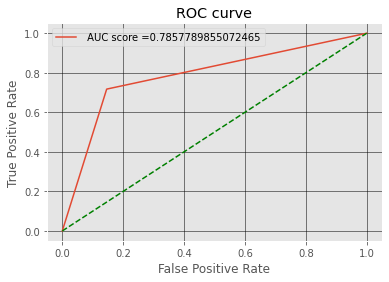

In [ ]:
# train_fpr, train_tpr, _ = roc_curve(y_train, y_train_pred)
testlabel[testlabel > 1] = 0
predicted_y[predicted_y>1] = 0
test_fpr, test_tpr, _ = roc_curve(testlabel, predicted_y)

plt.grid()

# plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC score ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

## Decision Tree

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

In [ ]:
predicted_train = clf.predict(traindata_fs)
print("Train Accuracy: ", metrics.accuracy_score(trainlabel, predicted_train))

predicted_y = clf.predict(testdata_fs)
tn, fp, fn, tp = confusion_matrix(testlabel, predicted_y).ravel()
specificity = tn / (tn+fp)

print("Test Accuracy: ", metrics.accuracy_score(testlabel, predicted_y))
print("Precision: ", metrics.precision_score(testlabel, predicted_y)) 
print("Sensitivity: ", metrics.recall_score(testlabel, predicted_y))
print("Specificity:", specificity)
print("f1: ", metrics.f1_score(testlabel, predicted_y))
print("Area Under Curve (AUC): ", metrics.roc_auc_score(testlabel, predicted_y))
print("Classification Report :  \n", classification_report(testlabel, predicted_y))

# uncomment below codes to print prediction and ground truth
# print("Prediction : ", predicted_y)
# print("Ground truth : ", testlabel.T[0])
# print("Accurately predicted ratio", np.sum(predicted_y==testlabel.T[0])/len(predicted_y))

Train Accuracy:  1.0
Test Accuracy:  0.648936170212766
Precision:  0.6274509803921569
Sensitivity:  0.6956521739130435
Specificity: 0.6956521739130435
f1:  0.6597938144329897
Area Under Curve (AUC):  0.649909420289855
Classification Report :  
               precision    recall  f1-score   support

           1       0.63      0.70      0.66        46
           2       0.67      0.60      0.64        48

    accuracy                           0.65        94
   macro avg       0.65      0.65      0.65        94
weighted avg       0.65      0.65      0.65        94



## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
predicted_train = neigh.predict(traindata_fs)
print("Train Accuracy: ", metrics.accuracy_score(trainlabel, predicted_train))

predicted_y = neigh.predict(testdata_fs)
tn, fp, fn, tp = confusion_matrix(testlabel, predicted_y).ravel()
specificity = tn / (tn+fp)

print("Test Accuracy: ", metrics.accuracy_score(testlabel, predicted_y))
print("Precision: ", metrics.precision_score(testlabel, predicted_y)) 
print("Sensitivity: ", metrics.recall_score(testlabel, predicted_y))
print("Specificity:", specificity)
print("f1: ", metrics.f1_score(testlabel, predicted_y))
print("Area Under Curve (AUC): ", metrics.roc_auc_score(testlabel, predicted_y))
print("Classification Report :  \n", classification_report(testlabel, predicted_y))

# uncomment below codes to print prediction and ground truth
# print("Prediction : ", predicted_y)
# print("Ground truth : ", testlabel.T[0])
# print("Accurately predicted ratio", np.sum(predicted_y==testlabel.T[0])/len(predicted_y))

Train Accuracy:  0.8302752293577982
Test Accuracy:  0.5851063829787234
Precision:  0.5777777777777777
Sensitivity:  0.5652173913043478
Specificity: 0.5652173913043478
f1:  0.5714285714285713
Area Under Curve (AUC):  0.5846920289855072
Classification Report :  
               precision    recall  f1-score   support

           1       0.58      0.57      0.57        46
           2       0.59      0.60      0.60        48

    accuracy                           0.59        94
   macro avg       0.58      0.58      0.58        94
weighted avg       0.58      0.59      0.58        94



## Poly SVM

In [ ]:
model = make_pipeline(StandardScaler(), SVC(kernel='poly', probability=True, verbose=1, gamma="auto"))
clf = model.fit(X, y)

[LibSVM]

In [ ]:
predicted_train = model.predict(traindata_fs)
print("Train Accuracy: ", metrics.accuracy_score(trainlabel, predicted_train))

predicted_y = model.predict(testdata_fs)
tn, fp, fn, tp = confusion_matrix(testlabel, predicted_y).ravel()
specificity = tn / (tn+fp)

print("Test Accuracy: ", metrics.accuracy_score(testlabel, predicted_y))
print("Precision: ", metrics.precision_score(testlabel, predicted_y)) 
print("Sensitivity: ", metrics.recall_score(testlabel, predicted_y))
print("Specificity:", specificity)
print("f1: ", metrics.f1_score(testlabel, predicted_y))
print("Area Under Curve (AUC): ", metrics.roc_auc_score(testlabel, predicted_y))
print("Classification Report :  \n", classification_report(testlabel, predicted_y))

# uncomment below codes to print prediction and ground truth
# print("Prediction : ", predicted_y)
# print("Ground truth : ", testlabel.T[0])
# print("Accurately predicted ratio", np.sum(predicted_y==testlabel.T[0])/len(predicted_y))

Train Accuracy:  0.8256880733944955
Test Accuracy:  0.6914893617021277
Precision:  0.7428571428571429
Sensitivity:  0.5652173913043478
Specificity: 0.5652173913043478
f1:  0.6419753086419753
Area Under Curve (AUC):  0.6888586956521741
Classification Report :  
               precision    recall  f1-score   support

           1       0.74      0.57      0.64        46
           2       0.66      0.81      0.73        48

    accuracy                           0.69        94
   macro avg       0.70      0.69      0.69        94
weighted avg       0.70      0.69      0.69        94



# Experiments

In [ ]:
traindata = []
trainlabel = []
testdata = []
testlabel = []

extracted_features = np.array(extracted_features)
for i in range(0,len(traindata_indices)):
  idx = traindata_indices[i][0]-1
  traindata.append(extracted_features[idx])
  trainlabel.append(traindata_labels[i][0])

for j in range(0,len(testdata_indices)):
  idx1 = testdata_indices[j][0]-1
  testdata.append(extracted_features[idx1])
  testlabel.append(testdata_labels[j][0])

traindata = pd.DataFrame(traindata); traindata.columns = title
testdata = pd.DataFrame(testdata); testdata.columns = title
trainlabel = pd.DataFrame(trainlabel)
testlabel = pd.DataFrame(testlabel)


In [ ]:
acc =[]
prec = []
recall = []
f1 =[]
AUC = []

for i in range (1,101):
  # print(f"Number of features selected {i}")
  ranking = RANKED[:i]

  # Train and test data after feature selection process
  train_fs = traindata.iloc[:, ranking]
  test_fs = testdata.iloc[:, ranking]

  X_f = np.array(train_fs)
  y_f = np.array(trainlabel)
  test_fs = np.array(test_fs)
  testlabel = np.array(testlabel)

  model = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True, verbose=0, gamma="auto"))
  clf = model.fit(X_f, y_f)

  predict_y = model.predict(test_fs)
  acc.append(metrics.accuracy_score(testlabel, predict_y))
  prec.append(metrics.precision_score(testlabel, predict_y)) 
  recall.append(metrics.recall_score(testlabel, predict_y))
  f1.append(metrics.f1_score(testlabel, predict_y))
  AUC.append(metrics.roc_auc_score(testlabel, predict_y))

(array([31, 32, 33]),)
(array([31, 32, 33]),)
(array([24, 25]),)
(array([31, 32, 33]),)
(array([31, 32, 33]),)


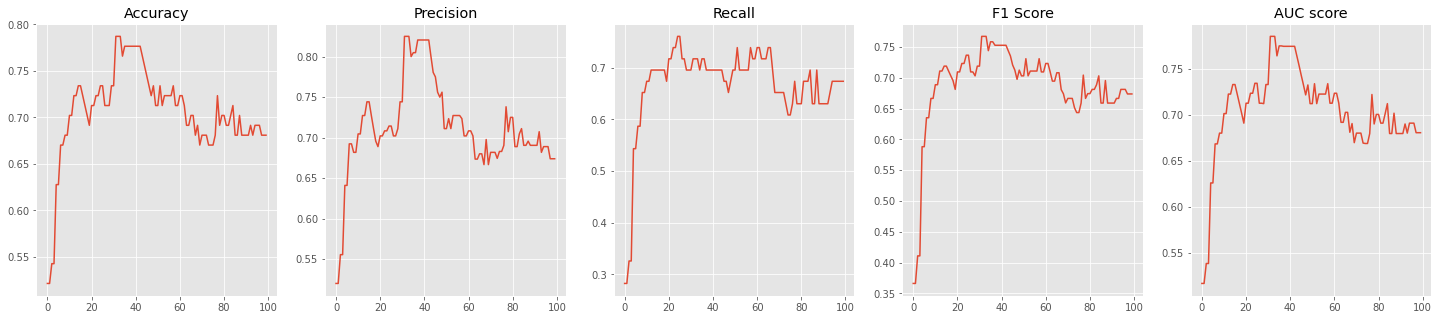

In [ ]:

fig, ax = plt.subplots(1,5, figsize=(25,5));
ax[0].plot(acc), ax[0].set_title(f'Accuracy');
ax[1].plot(prec), ax[1].set_title(f'Precision');
ax[2].plot(recall), ax[2].set_title(f'Recall');
ax[3].plot(f1), ax[3].set_title(f'F1 Score');
ax[4].plot(AUC), ax[4].set_title(f'AUC score');

print(np.where(acc==np.max(acc)))
print(np.where(prec==np.max(prec)))
print(np.where(recall==np.max(recall)))
print(np.where(f1==np.max(f1)))
print(np.where(AUC==np.max(AUC)))

# Statistical Test

In [ ]:
from scipy.stats import mannwhitneyu
test_1_stat = []
test_2_stat = []
testdata = np.array(testdata)
testlabel = np.array(testlabel)
for i in range(0,len(testlabel)):
  if testlabel[i] == 1:
    test_1_stat.append(testdata[i])
  else:
    test_2_stat.append(testdata[i])

#Convert to dataframe
test_1_stat = pd.DataFrame(test_1_stat,columns = title)
test_2_stat = pd.DataFrame(test_2_stat,columns = title)

In [ ]:
# Uncomment to print the dataframe
# test_1_stat

In [ ]:
test_1_stat_fs = test_1_stat
test_2_stat_fs = test_2_stat

# Uncomment below codes to perform significance test between selected features
# test_1_stat_fs = test_1_stat.iloc[:, ranking]
# test_2_stat_fs = test_2_stat.iloc[:, ranking]

title_fs = []
for col_name in test_1_stat_fs.columns: 
  # print(col_name)
  title_fs.append(col_name)


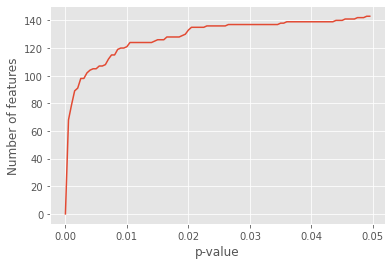

In [ ]:
p_values = []
for k in range (0,len(title_fs)):
  feature_1 = test_1_stat_fs[title_fs[k]]
  feature_2 = test_2_stat_fs[title_fs[k]]
  # print(feature_1)
  # print(feature_2)
  stat, p_value = mannwhitneyu(feature_1, feature_2, alternative='two-sided')
  p_values.append(p_value)
  
ranger = np.linspace(0, 0.05, 100, endpoint = False)
counter = []
for j in ranger:
  count = len([i for i in p_values if i < j])
  counter.append(count)

plt.plot(ranger, counter);
plt.xlabel('p-value');
plt.ylabel('Number of features');

# MISC

### CNN Classification

In [ ]:
from skimage.transform import resize
training_images = []
for j in range(0,len(labels)):
  A2_new, H2_new, V2_new, D2_new, A1_new, H1_new, V1_new, D1_new = discretize(data,j)
  # print(A2_new.shape)
  training_images.append(np.concatenate((resize(A2_new,(10,10)), resize(H2_new,(10,10)), resize(V2_new,(10,10)), resize(D2_new,(10,10)), resize(A1_new,(10,10)), resize(H1_new,(10,10)), resize(V1_new,(10,10)), resize(D1_new,(10,10))),axis=1))
  # print(concat_image.shape)


312


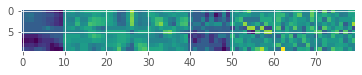

In [ ]:
training_images[0].shape
plt.imshow(training_images[0])
print(len(training_images))

In [ ]:
traindata = []
trainlabel = []
testdata = []
testlabel = []

for i in range(0,len(traindata_indices)):
  idx = traindata_indices[i][0]-1
  traindata.append(training_images[idx])
  trainlabel.append(traindata_labels[i][0])
# print(len(traindata))
# print(len(trainlabel))

for j in range(0,len(testdata_indices)):
  idx1 = testdata_indices[j][0]-1
  testdata.append(training_images[idx1])
  testlabel.append(testdata_labels[j][0])
# print(len(testdata))
# print(len(testlabel))

traindata = np.array(traindata)
testdata = np.array(testdata)
trainlabel = np.array(trainlabel)
testlabel = np.array(testlabel)

trainlabel[trainlabel > 1] = 0
testlabel[testlabel > 1] = 0

In [ ]:
testdata.shape

(94, 10, 80)

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(10, 80,1)))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 79, 32)         160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 39, 32)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4992)              0         
                                                                 
 dense (Dense)               (None, 64)                319552    
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                        

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(traindata, trainlabel, epochs=10,  validation_data=(testdata, testlabel))

Epoch 1/10
7/7 [==============================] - 1s 42ms/step - loss: 0.6932 - accuracy: 0.5092 - val_loss: 0.6930 - val_accuracy: 0.5106
Epoch 2/10
7/7 [==============================] - 0s 17ms/step - loss: 0.6931 - accuracy: 0.5092 - val_loss: 0.6930 - val_accuracy: 0.5106
Epoch 3/10
7/7 [==============================] - 0s 16ms/step - loss: 0.6931 - accuracy: 0.5092 - val_loss: 0.6930 - val_accuracy: 0.5106
Epoch 4/10
7/7 [==============================] - 0s 15ms/step - loss: 0.6931 - accuracy: 0.5092 - val_loss: 0.6930 - val_accuracy: 0.5106
Epoch 5/10
7/7 [==============================] - 0s 19ms/step - loss: 0.6930 - accuracy: 0.5092 - val_loss: 0.6930 - val_accuracy: 0.5106
Epoch 6/10
7/7 [==============================] - 0s 16ms/step - loss: 0.6931 - accuracy: 0.5092 - val_loss: 0.6930 - val_accuracy: 0.5106
Epoch 7/10
7/7 [==============================] - 0s 15ms/step - loss: 0.6930 - accuracy: 0.5092 - val_loss: 0.6930 - val_accuracy: 0.5106
Epoch 8/10
7/7 [===========

3/3 - 0s - loss: 0.6929 - accuracy: 0.5106 - 35ms/epoch - 12ms/step


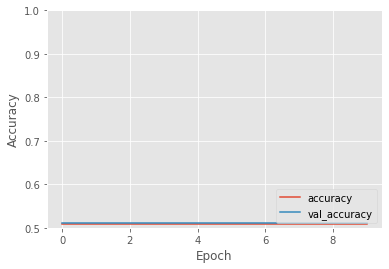

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(testdata,  testlabel, verbose=2)

## Extra

In [ ]:
# # Infinite Feature Selection.
# # https://pypi.org/project/PyIFS/
# # Inputs:
# #   x_train: matrix T (samples) by n (number of features).
# #   y_train: column vector of labels (-1,1).
# #   verbose: boolean variable.

# # Outputs:
# #   RANKED: vector of indicies of x_train from the best to the worst feature.

# import numpy as np
# import math
# # import stats

# class InfFS:

#     def __init__(self):
#         h=0.1
#         #print("HI")
#     # Take in input the matrix e the label vector and return a matrix
#     # of data for every different label.
#     def takeLabel(self, x_train, y_train ):
#         counter = x_train.shape[0] -1
#         s_n = x_train
#         s_p = x_train
#         while(1):
#             if( y_train[counter] == 1 ):
#                 s_n = np.delete(s_n, counter, axis = 0 )
#             else:
#                 s_p = np.delete(s_p, counter, axis = 0 )
#             counter = counter - 1
#             if( counter == - 1 ):
#                 break
#         return s_p, s_n

#     # Function that help to define priors_corr.
#     def defPriorsCorr(self,mu_s_n, mu_s_p):
#         pcorr = mu_s_p
#         counter = 0
#         while( counter < len(pcorr) ):
#             pcorr[counter] = (pcorr[counter] - mu_s_n[counter])*(pcorr[counter] - mu_s_n[counter])
#             counter = counter + 1
#         return pcorr

#     # Function to subtract the min value of the matrix to all it's elements.
#     def SubtractMin(self, corr_ij ):
#         m = 10100
#         for i in range(0,corr_ij.shape[0]): # Find the min.
#             for j in range(0,corr_ij.shape[1]):
#                 if( corr_ij[i,j] < m ):
#                     m = corr_ij[i,j]

#         for i in range(0,corr_ij.shape[0]): # Subtract the min value.
#             for j in range(0,corr_ij.shape[1]):
#                 corr_ij[i,j] = corr_ij[i,j] - m

#         return corr_ij

#     # Function to divide every element of the matrix to his maximum value.
#     def DivideByMax(self,corr_ij):
#         m = -1
#         for i in range(0,corr_ij.shape[0]): # Find the max.s
#             for j in range(0,corr_ij.shape[1]):
#                 if( corr_ij[i,j] > m ):
#                     m = corr_ij[i,j]

#         for i in range(0,corr_ij.shape[0]): # Divide by the maximum value.
#             for j in range(0,corr_ij.shape[1]):
#                 corr_ij[i,j] = corr_ij[i,j] / m

#         return corr_ij

#     # Handmaded bsxfunction that take the max.
#     def bsxfun(self, STD ):
#         m = np.zeros( (STD.shape[0], STD.shape[0]) )
#         for i in range( 0,STD.shape[0] ):
#             for j in range( 0,STD.shape[0] ):
#                 if( STD[i] > STD[j] ):
#                     m[i,j] = STD[i]
#                 else:
#                     m[i,j] = STD[j]
#         return m

#     def infFS(self,x_train, y_train, alpha, supervision, verbose):
#         # Start of point one.

#         if supervision:
#             s_p, s_n = self.takeLabel( x_train, y_train)
#             mu_s_n = s_n.mean(0)
#             mu_s_p = s_p.mean(0)
#             priors_corr = self.defPriorsCorr(mu_s_n, mu_s_p)
#             st = np.power(np.std(s_p, ddof = 1, axis = 0),2)
#             st = st + np.power(np.std(s_n,ddof = 1, axis = 0),2)
#             for i in range(0,len(st)):
#                 if st[i] == 0:
#                     st[i] = 10000
#             corr_ij = priors_corr
#             for i in range(0,len(corr_ij)):
#                 corr_ij[i] = corr_ij[i] / st[i]
#             corr_ij = np.dot( corr_ij.T[:,None], corr_ij[None,:])
#             corr_ij = self.SubtractMin(corr_ij)
#             corr_ij = self.DivideByMax(corr_ij)
#         else:
#             corr_ij, pval = stats.spearmanr(x_train)
#             for i in range( 0,corr_ij.shape[0] ):
#                 for j in range( 0,corr_ij.shape[1] ):
#                     if( math.isnan(corr_ij[i,j]) or corr_ij[i,j] < -1 or corr_ij[i,j] > 1 ):
#                         corr_ij[i,j] = 0

#         # After if.
#         STD = np.std(x_train, ddof = 1, axis = 0)
#         STDMatrix = self.bsxfun( STD )
#         STDMatrix = self.SubtractMin(STDMatrix)
#         sigma_ij = self.DivideByMax(STDMatrix)
#         for i in range( 0,sigma_ij.shape[0] ):
#             for j in range( 0,sigma_ij.shape[1] ):
#                 if( math.isnan(sigma_ij[i,j]) or sigma_ij[i,j] < -1 or sigma_ij[i,j] > 1 ):
#                     sigma_ij[i,j] = 0

#         # End of point one.

#         # Start of the point two.
#         if (verbose):
#             print("2) Building the graph G = <V,E> \n");
#         A =  ( alpha*corr_ij + (1-alpha)*sigma_ij );
#         # End of the point two.

#         # Start of the point three.
#         if (verbose):
#             print("3) Letting paths tend to infinite \n");

#         I = np.identity( A.shape[0] )
#         r = ( 0.9/ max( np.linalg.eigvals(A) ) ) # Setting the r values.
#         y = I - ( r * A )
#         S = np.linalg.inv( y ) - I
#         # End of point three.

#         # Start of point four.
#         if (verbose):
#             print("4) Estimating energy scores \n")

#         WEIGHT = np.sum( S , axis=1 )
#         # End of point four.

#         # Start of point five.
#         if(verbose):
#             print("5) Features ranking")

#         RANKED = np.argsort(WEIGHT)
#         RANKED = np.flip(RANKED,0)
#         RANKED = RANKED.T
#         WEIGHT = WEIGHT.T
#         return RANKED, WEIGHT
#         # End of point five.
